One of the main unsupervised learning techniques is called clustering.
Senators typically vote in accordance with how their political party votes,
known as voting along party lines. In the US, the 2 main political parties are
the Democrats , who tend to be liberal , and the Republicans , who tend to be
conservative . Senators can also choose to be unaffiliated with a party, and
vote as Independents, although very few choose to do so.
Clustering voting data of Senators is particularly interesting because it can
expose patterns that go deeper than party affiliation. For example, some
Republicans are more liberal than the rest of their party. Looking at voting
data can help us discover the Senators who are more or less in the
mainstream of their party.

In [11]:
import pandas as pd
votes = pd.read_csv("114_congress.csv")

In [12]:
print votes.head() 

        name party state  00001  00004  00005  00006  00007  00008  00009  \
0  Alexander     R    TN      0      1      1      1      1      0      0   
1     Ayotte     R    NH      0      1      1      1      1      0      0   
2    Baldwin     D    WI      1      0      0      1      0      1      0   
3   Barrasso     R    WY      0      1      1      1      1      0      1   
4     Bennet     D    CO      0      0      0      1      0      1      0   

   00010  00020  00026  00032  00038  00039  00044  00047  
0      1      1      1      0      0      0      0      0  
1      1      0      1      0      1      0      1      0  
2      1      0      0      1      1      0      1      1  
3      1      1      1      0      0      1      0      0  
4      1      0      0      0      1      0      1      0  


In [13]:
#Find how many Senators are in each party.
print (votes["party"].value_counts())

R    54
D    44
I     2
dtype: int64


In [14]:
#Finding what the "avaerage" vote for each bill was.
#Use the mean() method on the votes Dataframe. If the mean for a column is less than .5, more Senators voted against the bill, and vice versa if it's over .5. Print the results.
print (votes.mean())

00001    0.325
00004    0.575
00005    0.535
00006    0.945
00007    0.545
00008    0.415
00009    0.545
00010    0.985
00020    0.525
00026    0.545
00032    0.410
00038    0.480
00039    0.510
00044    0.460
00047    0.370
dtype: float64


In [5]:
from sklearn.metrics.pairwise import euclidean_distances
#Compute the Euclidean distance between the first row and the third row.
#(select columns after the first 3 because the first 3 are
#name , party , and state , which are not numeric.)
distance = euclidean_distances(votes.iloc[0,3:], votes.iloc[2,3:])
distance

array([[ 3.31662479]])

In [6]:
#kmeans clustering uses Euclidean distance to form clusters of similar Senators.
#Each cluster is assigned a center, and the Euclidean distance from each 
#Senator to the center is computed. Senators are assigned
#to clusters based on which one they are closest to.

import pandas as pd
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=2, random_state=1)

#Because we aren't predicting anything, there's no risk of overfitting, so we'll
#train our model on the whole dataset. After training, we'll be able to extract
#cluster labels that indicate what cluster each Senator belongs to.
#Use the fit_transform() method to fit kmeans_model on the votes DataFrame. 
#Only select columns after the first 3 from votes when fitting.

senator_distances = kmeans_model.fit_transform(votes.iloc[:,3:])

In [17]:
#Use the labels_ attribute to extract the cluster labels for each Senator from 
#kmeans_model
labels = kmeans_model.labels_

#The crosstab() method takes in two vectors or Pandas Series and computes how
#many times each unique value in the second vector occurs for each unique value
#in the first vector.
#Creating a table comparing labels to votes["party"], in that order.
print(pd.crosstab(labels, votes["party"]))

#This will show us if the clusters tend to break down along party lines or not.

party   D  I   R
row_0           
0      41  2   0
1       3  0  54


Result: both of our clusters mostly broke down along party lines. The
first cluster contains 41 Democrats, and both Independents. The second
cluster contains 3 Democrats, and 54 Republicans. No Republicans seem to have broken party ranks to vote with the Democrats, but 3 Democrats are more similar to Republicans in their voting than their own party. (0: cluster1, 1:cluster2)

To explore these 3 in more depth (so we can figure out why that
is)- by subsetting votes to only select rows where the party
column is D , and the labels variable is 1 , indicating that the Senator is in the second cluster. We can perform this subsetting with Pandas.

In [8]:
#Subsetting, i.e., Selecting all Independents in the first cluster:
#votes[(labels == 0) & (votes["party"] == "I")]


#Selecting all Democrats in votes who were assigned to the first cluster.
democratic_outliers = votes[(labels == 1) & (votes["party"] == "D")]
print (democratic_outliers)

        name party state  00001  00004  00005  00006  00007  00008  00009  \
42  Heitkamp     D    ND    0.0    1.0    0.0    1.0    0.0    0.0    1.0   
56   Manchin     D    WV    0.0    1.0    0.0    1.0    0.0    0.0    1.0   
74      Reid     D    NV    0.5    0.5    0.5    0.5    0.5    0.5    0.5   

    00010  00020  00026  00032  00038  00039  00044  00047  
42    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0  
56    1.0    1.0    0.0    0.0    1.0    1.0    0.0    0.0  
74    0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5  


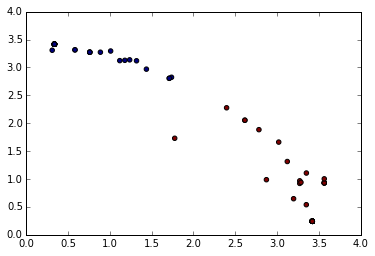

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline


#x should be the first column of senator_distances. y should be the second column
#of senator_distances. c should be labels. 
#This will shade the points according to label.
plt.scatter(x=senator_distances[:,0], y=senator_distances[:,1], c=labels)
plt.show()

The most extreme Senators are those who are the furthest away from one
cluster. For example, a radical Republican would be as far from the
Democratic cluster as possible. Senators who are in between both clusters are
more moderate, as they fall i/n between the views of the two parties. (See notes)

In [19]:
#Compute an extremism rating by cubing every value in senator_distances, then finding the sum across each row. Assign the result to extremism.
#Assign the extremism variable to the extremism column of votes.
#Sort votes on the extremism column, in descending order, using the sort_values() method on DataFrames.
#Print the top 10 most extreme Senators.

#(The higher the exponent we raise a set of numbers to, the more separation 
#we'll see between small values and low values.)
extremism = (senator_distances ** 3).sum(axis=1)

votes["extremism"] = extremism

votes.sort_values("extremism", inplace=True, ascending=False)

print(votes.head(10))

#Python 3 error maybe?

AttributeError: 'DataFrame' object has no attribute 'sort_values'